# CS5100 Final Project

Name: Trenton Creamer

Goal: This assignment will allow you to apply your knowledge of machine learning that you have aquired in this course on a real-world dataset of your choosing per the assignment specifications.

Complete the notebook and demonstrate your mastery of the topic.

## Prerequisites

In this section describe any packages that need to be installed or any additional setup that needs to take place before trying to run code.

All of the require packages I have included in the necessary code blocks below. You just need to run the code from the beginning, code block by code block, and the code should run correctly. I have listed all of my import below.

Import List:

import numpy as np

import matplotlib.pyplot as plt

from utility.util import configure_plots

configure_plots()

from sklearn.preprocessing import normalize

from utility.util import pair_plot

from sklearn.model_selection import train_test_split

from utility.util import Model

import datetime

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier


## Problem

In this section, you will explain the problem you are trying to solve, the things you are trying to learn, and how you want to visualize the results.

I want to use this machine learning model to better predict patterns and trends in 911 calls. This could help the Seattle police department with staffing and resource allocation. If they know that certain 911 calls are more frequent during different seasons or during times of the day, then they can be better prepared for this. 

I will run my machine learning model to predict when different types of events will occur in different times of the day. I will visualize these trends and will also visualize data if they are more likely to occur during certain times of the day than othes.

## Data

In this section you will describe the dataset (corpus) you are using. Explain who collected the data, how they did it, the manner in which it was stored, the way you accessed the data, what steps you will have to do to clean it, and so on. Provide any relavent details.

My data set is coming from data.seattle.gov. It is data that is collected from the Seattle city government and is a collection of all the 911 calls they received. Thed data set has existed since January 8th 2010 and appears to be updated every week. The data uncleaned has 1.79M rows of data and comes in CSV format. For my project, I will removed the data up until the last year. This made my dataset more manageable to work with. I primarily want to work with the events and dates columns, so I had to convert the string timestamp into a useable format. For this I used a datetime object and converted the data to a more usable form. Once I had a datetime object, I then placed time ranges into different categories. I also conveted the latitude and longitude strings to floats to be used in my analysis.

## Cleaning the Data

Add the code to download/query you data. If your data is already downloaded, then load it into your program here. Then add the code to clean it.

In [1212]:
def parse_csv(line):
    return line.strip().split(',')

def load_data(path, parsefn):
    with open(path) as file:
        return [parsefn(line) for line in file]

# Using data from the last month. I tried using data from this year, but it was too much for the ml model to handle.
police_call_data = load_data('April_2023_Seattle_Real_Time_Fire_911_Calls copy.csv', parse_csv)

headings, data = police_call_data[0], police_call_data[1:]

# Data before we clean it 
print(headings)
for i in range(5):
    print(data[i])


['Address', 'Type', 'Datetime', 'Latitude', 'Longitude', 'Report Location', 'Incident Number']
['13554 22nd Ave Ne', 'Medic Response', '4/1/23 0:05', '47.727309', '-122.305317', 'POINT (-122.305317 47.727309)', 'F230039339']
['33rd Ave Ne / Ne 75th St', 'Aid Response', '4/1/23 0:14', '47.683048', '-122.292639', 'POINT (-122.292639 47.683048)', 'F230039340']
['2020 S Jackson St', 'Medic Response- 7 per Rule', '4/1/23 0:16', '47.599261', '-122.305296', 'POINT (-122.305296 47.599261)', 'F230039341']
['1215 Thomas St', 'Medic Response', '4/1/23 0:24', '47.620815', '-122.332585', 'POINT (-122.332585 47.620815)', 'F230039342']
['105 W Mercer St', 'Aid Response', '4/1/23 0:26', '47.624588', '-122.358069', 'POINT (-122.358069 47.624588)', 'F230039343']


In [1213]:
from datetime import datetime

# Datetime format I will be converting to 
datetime_format = '%m/%d/%y %H:%M'

# Encode the timestamps by morning, afternoon evening 
headings.append("Time of the Day")
headings.append("Time of the Day Numeric")

time_ranges = [(4,10), (11,16), (17,20), (21,23), (0,3)]
labels = ['Morning', 'Afternoon', 'Evening', 'Late Night', 'Early Morning']

# New Heading to Label our Days of the Week
headings.append("Day of the week")

# Getting the Datetime columen to reference in our conversion
datetime_col_index = headings.index('Datetime')

# Convert each datetime string to a timestamp data type
for row in data:
    # Getting the datetime string 
    datetime_string = row[datetime_col_index]
    # Convert the string to a datetime object 
    datetime_object = datetime.strptime(datetime_string, datetime_format)

    # Extract the hours out of our datetime object so we know how to encode and label by hour range
    hour = datetime_object.hour

    # Creating a Time of Day column with our labeled data 
    for i, tr in enumerate(time_ranges):
        # Making sure the value is in the correct range
        if tr[0] <= hour <= tr[1]:
            row.append(labels[i])
            # Also append the numeric value for our machine learning model later
            row.append(int(i))
            break

    # Getting the day of the week for this line of data
    day_name = datetime_object.strftime("%A")
    # Append the day of the week to our day of the week column
    row.append(day_name)

    # Update our datetime string with the converted datetime object
    row[datetime_col_index] = datetime_object



In [1214]:
# Convert the long and lat to floats 
latitude_col_index = headings.index('Latitude')
longitude_col_index = headings.index('Longitude')
for row in data:
    lat_string = row[latitude_col_index]
    long_string = row[longitude_col_index]
    # only attempt conversion if the values are not empty 
    # This will handle Null value errors 
    if lat_string and long_string: 
        row[latitude_col_index] = float(lat_string)
        row[longitude_col_index] = float(long_string)

    else:
        row[latitude_col_index] = 0.0
        row[longitude_col_index] = 0.0

# Check that we have cleaned all of our data completely
print(len(headings))
print(len(data[0]))
print(len(data))
print(headings)
for i in range(51):
    print(data[i])



10
10
2478
['Address', 'Type', 'Datetime', 'Latitude', 'Longitude', 'Report Location', 'Incident Number', 'Time of the Day', 'Time of the Day Numeric', 'Day of the week']
['13554 22nd Ave Ne', 'Medic Response', datetime.datetime(2023, 4, 1, 0, 5), 47.727309, -122.305317, 'POINT (-122.305317 47.727309)', 'F230039339', 'Early Morning', 4, 'Saturday']
['33rd Ave Ne / Ne 75th St', 'Aid Response', datetime.datetime(2023, 4, 1, 0, 14), 47.683048, -122.292639, 'POINT (-122.292639 47.683048)', 'F230039340', 'Early Morning', 4, 'Saturday']
['2020 S Jackson St', 'Medic Response- 7 per Rule', datetime.datetime(2023, 4, 1, 0, 16), 47.599261, -122.305296, 'POINT (-122.305296 47.599261)', 'F230039341', 'Early Morning', 4, 'Saturday']
['1215 Thomas St', 'Medic Response', datetime.datetime(2023, 4, 1, 0, 24), 47.620815, -122.332585, 'POINT (-122.332585 47.620815)', 'F230039342', 'Early Morning', 4, 'Saturday']
['105 W Mercer St', 'Aid Response', datetime.datetime(2023, 4, 1, 0, 26), 47.624588, -122.35

## Learning Model

In detailed and documented Python, walk the user through your code below similar to the Twitter assignment.

In [1216]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
#Import to label our string data to be handled by themodel
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# We have an idea of what types of events are happening at what times in the day and what frequencies, 
# We will build a model that can classify events by the time of the day they are likely to occur 

# Making training and testing sets for the data 
# Going to train the data to predict what time of the day events are most likely to occur 
import numpy as np
data = np.array(data)
# X is everything up to colum 7 and y is column 8 , column y is the time of the day 
# skipping the datetime object as it is giving issues in the ml model
# Convert labels to integers using LabelEncoder
encode = LabelEncoder()

# Encoding column 8 so out ml model can process the data 
y = encode.fit_transform(data[:, 8])

# X is everything up to column 7 and y is column 8, which is the Time of the Day
# Everything together has a fscore of 34%
#X, y = data[:, :7], y
# Just looking at event labels we have a score of 43%
x, y = data[:, [1]], y

print(x)
# print(X)
print(y)

# Encode categorical values
enc = OneHotEncoder()
x_encoded = enc.fit_transform(x)

# Split data into training and testing sets
x_train, X_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.3, random_state=217)
# 1734 lines of data for our training set
print(x_train.shape)
print(y_train.shape)

# 744 lines of data for out testing set 
print(X_test.shape)
print(y_test.shape)


[['Medic Response']
 ['Aid Response']
 ['Medic Response- 7 per Rule']
 ...
 ['Medic Response']
 ['Aid Response']
 ['Triaged Incident']]
[4 4 4 ... 2 2 2]
(1734, 60)
(1734,)
(744, 60)
(744,)


In [1217]:
#Import to label our string data to be handled by themodel
from sklearn.ensemble import RandomForestClassifier
#Import to see the accuracy
from sklearn.metrics import accuracy_score

# Import to see the classification report 
from sklearn.metrics import classification_report

rf = RandomForestClassifier()

# Use a different classifier naive bayes - simple classification - neural networks (defaults )
rf.fit(x_train, y_train)

# Predict target variable for testing data
y_pred = rf.predict(X_test)
# print(y_pred) 

# Accuracy score of the Random Forest Model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest Model  ", accuracy)

# Classification report
print(classification_report(y_test, y_pred))



Accuracy of Random Forest Model   0.3400537634408602
              precision    recall  f1-score   support

           0       0.34      0.20      0.25       183
           1       0.35      0.85      0.49       252
           2       0.16      0.02      0.04       145
           3       0.25      0.01      0.03        71
           4       0.00      0.00      0.00        93

    accuracy                           0.34       744
   macro avg       0.22      0.22      0.16       744
weighted avg       0.26      0.34      0.24       744



In [1219]:
from sklearn.naive_bayes import GaussianNB
#Import to see the accuracy
from sklearn.metrics import accuracy_score

# Import to see the classification report 
from sklearn.metrics import classification_report

# Fit Training data to Naive Bayes Model
nb = GaussianNB()
nb.fit(x_train.toarray(), y_train)

# Predict the target variable for testing data
y_pred = nb.predict(X_test.toarray())

# Accuracy score of the Naive Bayes Model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Naive Bayes Model  ", accuracy)

# # Classification report
# print(classification_report(y_test, y_pred))


Accuracy of Naive Bayes Model   0.12231182795698925


## Tuning and Feature Extraction

Add and describe code to perform Hyperparameter Tuning and Feature Extraction or PCA.

In [1226]:
# Tuning our random forest model
# n_estimates: number of trees in the forest
# max_depth: max depth of each decision tree
# max_features = number of features to consider when looking for best fit 

# Accuracy = .36
rf = RandomForestClassifier(n_estimators=15, max_depth=140,  min_samples_leaf=1, max_features='sqrt')

#  Accuracy = .338
# rf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=15, min_samples_leaf=3, max_features='log2')

# Accuracy = .338
# rf = RandomForestClassifier(n_estimators=150, max_depth=30, min_samples_leaf=5)

# Accuracy = .345
# rf = RandomForestClassifier()


rf.fit(x_train, y_train)

# Predict target variable for testing data
y_pred = rf.predict(X_test)
# print(y_pred) 

# Accuracy score of the Random Forest Model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest Model  ", accuracy)

# Classification report
print(classification_report(y_test, y_pred))



Accuracy of Random Forest Model   0.35618279569892475
              precision    recall  f1-score   support

           0       0.43      0.13      0.19       183
           1       0.35      0.94      0.51       252
           2       0.33      0.01      0.03       145
           3       0.11      0.01      0.03        71
           4       0.33      0.01      0.02        93

    accuracy                           0.36       744
   macro avg       0.31      0.22      0.16       744
weighted avg       0.34      0.36      0.23       744



In [1223]:
from sklearn.model_selection import cross_val_score
# Cross-validation
scores = cross_val_score(rf, x_encoded, y, cv=7)

# Print the scores of the k cross validations
print(np.mean(scores))


0.32687651331719125


In [1224]:
# Running our Random Forest Model with everything but the datetime data to check accuracy - this turns out to be lower
# than just running the model on the events column

y = encode.fit_transform(data[:, 8])

# x, y = data[:, :7], y
x, y = data[:, [0,1,3,4,5,6]], y
print(x)

# One-Hot Encode categorical variables
enc = OneHotEncoder()
x_encoded = enc.fit_transform(x)

# Split data into training and testing sets
x_train, X_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.3, random_state=217)

# Create Random Forest Classifier object - max accuracy of .34
rf = RandomForestClassifier()
# rf = RandomForestClassifier(n_estimators=15, max_depth=140,  min_samples_leaf=1, max_features='sqrt')


# Max accuract of .34
#rf = RandomForestClassifier(n_estimators=15, max_depth=140,  min_samples_leaf=1, max_features='sqrt')

# Use a different classifier naive bayes - simple classification - neural networks (defaults )
rf.fit(x_train, y_train)

# Predict target variable for testing data
y_pred = rf.predict(X_test)

# Accuracy score of the Random Forest Model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest Model  ", accuracy)

# Classification report
print(classification_report(y_test, y_pred))

[['13554 22nd Ave Ne' 'Medic Response' 47.727309 -122.305317
  'POINT (-122.305317 47.727309)' 'F230039339']
 ['33rd Ave Ne / Ne 75th St' 'Aid Response' 47.683048 -122.292639
  'POINT (-122.292639 47.683048)' 'F230039340']
 ['2020 S Jackson St' 'Medic Response- 7 per Rule' 47.599261 -122.305296
  'POINT (-122.305296 47.599261)' 'F230039341']
 ...
 ['334 1st Ave N' 'Medic Response' 47.621329 -122.355431
  'POINT (-122.355431 47.621329)' 'F230042609']
 ['4731 22nd Ave Sw' 'Aid Response' 47.560536 -122.36112
  'POINT (-122.36112 47.560536)' 'F230042610']
 ['820 Nw 95th St' 'Triaged Incident' 47.697867 -122.367016
  'POINT (-122.367016 47.697867)' 'F230042611']]
Accuracy of Random Forest Model   0.34139784946236557
              precision    recall  f1-score   support

           0       0.34      0.09      0.14       183
           1       0.35      0.91      0.51       252
           2       0.17      0.01      0.03       145
           3       0.15      0.03      0.05        71
        

In [1228]:
# Second model - Tuning our Naive Bayes

# Fit Training data to Naive Bayes Model
# Adding smoothing about doubles the accurace of the results! 
nb = GaussianNB(var_smoothing=.65)


nb.fit(x_train.toarray(), y_train)

# Predict the target variable for testing data
y_pred = nb.predict(X_test.toarray())

# Accuracy score of the Naive Bayes Model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Naive Bayes Model  ", accuracy)

Accuracy of Naive Bayes Model   0.3521505376344086


In [1229]:
# Naive Bayes Cross Validation
# Cross-validation
scores = cross_val_score(nb, x_encoded.toarray(), y, cv=8)


# Print the scores of the k cross validations
print(np.mean(scores))
print(scores)


0.3252492431360267
[0.31612903 0.30645161 0.35483871 0.3483871  0.34193548 0.31612903
 0.30420712 0.31391586]


## Visuals

Below, generate the visuals that will explain the results you are getting and show what you hoped to learn from the data.

In [1206]:

%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
from utility.util import configure_plots

configure_plots()



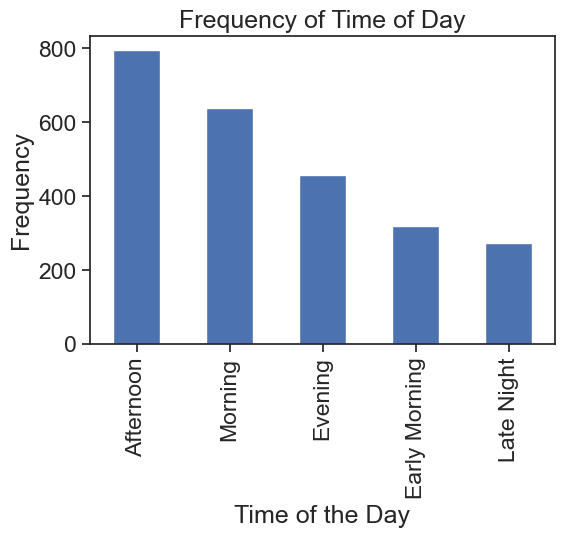

In [1230]:
# Create a dataframe object with our data and column headings, data object will look similiar to a spreadsheet 
df = pd.DataFrame(data, columns=headings)
# print(df)

# Count the number of occurrences of each unique Time of the Day value
time_of_day_counts = df['Time of the Day'].value_counts()

# Create a bar chart of the Time of the Day counts
time_of_day_counts.plot(kind='bar', figsize=(6,4))
plt.xlabel('Time of the Day')
plt.ylabel('Frequency')
plt.title('Frequency of Time of Day')
plt.show()

Saturday     592
Thursday     346
Friday       334
Wednesday    308
Monday       302
Tuesday      299
Sunday       297
Name: Day of the week, dtype: int64


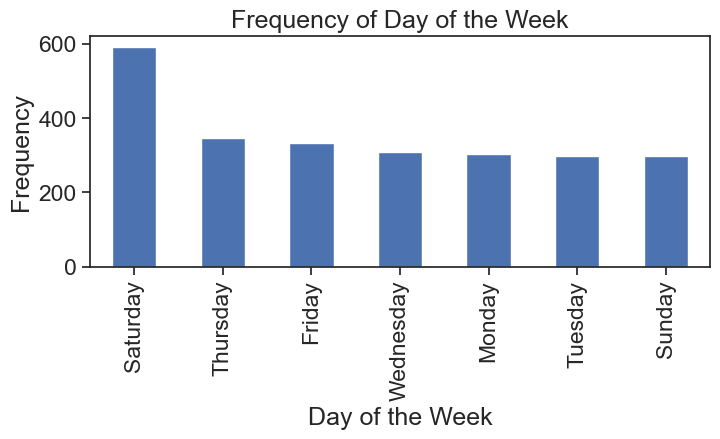

In [1208]:
# Count the number of occurrences of each value in the day of the week column 
time_of_day_counts = df['Day of the week'].value_counts()
print(time_of_day_counts)

# Bar chart to show the counts of event at different times in the day 
time_of_day_counts.plot(kind='bar', figsize=(8,3))
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Frequency of Day of the Week')
plt.show()

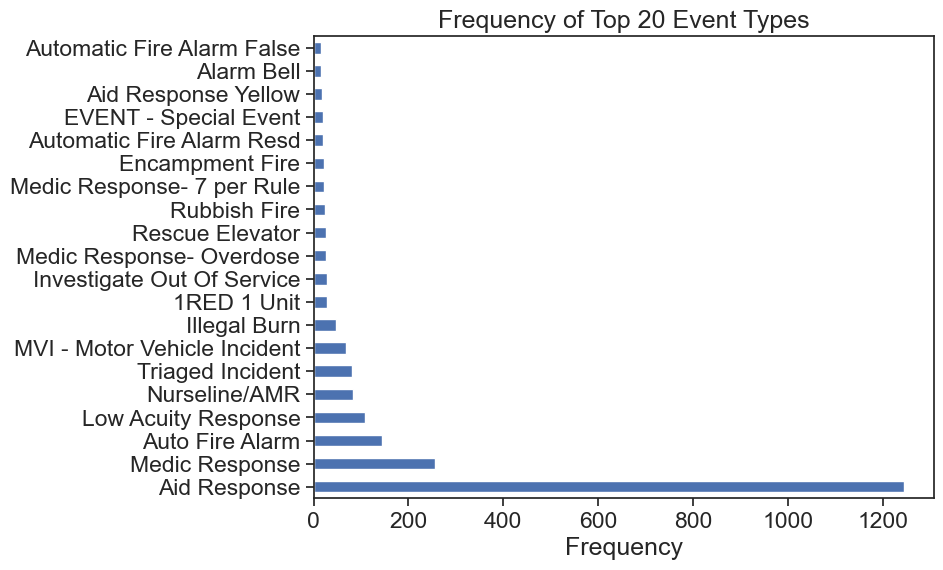

In [1231]:
# Count the number of occurrences of each unique event type
event_type_counts = df['Type'].value_counts()

# Select only the top 20 event types by frequency
top_event_types = event_type_counts.nlargest(20)

# Horizontal bar chart of the top 20 events
plt.figure(figsize=(8, 6))
# barh = bar horizontal 
top_event_types.plot(kind='barh')
plt.xlabel('Frequency')
plt.title('Frequency of Top 20 Event Types')
plt.show()

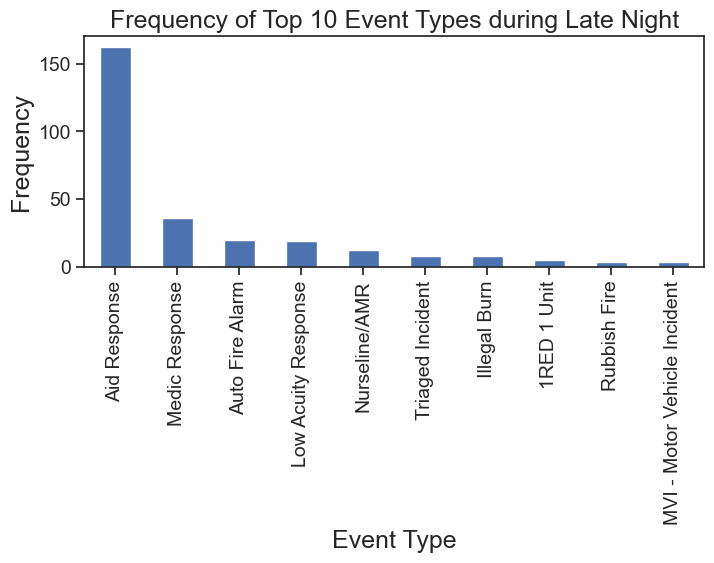

In [1232]:
# Filter the data to include only events that occur during the Late Night time period
df_late_night = df[df['Time of the Day'] == 'Early Morning']

# Count the frequency of each event type during the Late Night time period
event_type_counts = df_late_night['Type'].value_counts()

# Limit to top 10 event types
event_type_counts = event_type_counts.head(10)

# Create a bar chart of the frequency of each event type during the Late Night time period
event_type_counts.plot(kind='bar', figsize=(8, 3))

plt.xlabel('Event Type')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Event Types during Late Night', fontsize=18)
plt.tick_params(labelsize=14)

plt.show()

2478


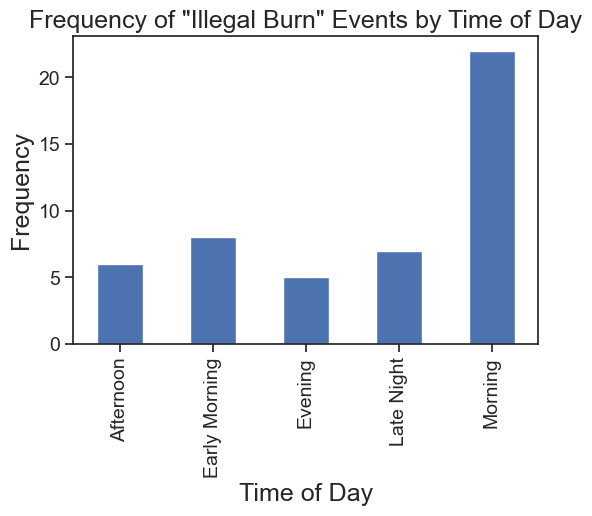

In [1233]:
df = pd.DataFrame(data, columns=headings)
print(len(df))

# Filter data by the event type Illegal Burn
df_violence = df[df['Type'] == 'Illegal Burn']

# Use panda dataframe to group by Time of the and the count, similiar to a pivot table tin Excel
time_of_day_counts = df_violence.groupby('Time of the Day')['Time of the Day'].count()

time_of_day_counts.plot(kind='bar', figsize=(6,4))

plt.xlabel('Time of Day')
plt.ylabel('Frequency')
plt.title('Frequency of "Illegal Burn" Events by Time of Day', fontsize=18)
plt.tick_params(labelsize=14)

# Show the plot
plt.show()

## Reflection

1. What issues did you encounter when aquiring and cleaning the data?
    I had a few issues with working with my data set. The first issue was the sheer size of the data. I originally had over 1.4M lines of data. I first had to reduce the size of my CSV file to have a reasonable amount of data to work with. I also had to do this so my ml models could train in a reasonable amount of time. I ended up reducing my data to have CSVs with data within the last month which has 2500 lines of data. I tried using data from 2023, but my models took too long to run. The other major issue I had was with the format my data was in. The data I wanted to analyze was in timestamp format.

2. What features did you use in your final model and why were others excluded?
    I tested with different features to see what would produce the best accuracy. I made sure to exclude the timestamp data as I am predicting when in the day an event might occur. I tried using all of the columns but the timestamp column and the accuracy was a few percent lower than just using the event column by itself. For this reason, I decided to train my models on the events column data.

3. Which ML methods did you use and why? Which performed best before you started tuning? Did things change after tuning?
    Since the relationship between event and time of day could be fairly complex, I used random forests as my first model. Using multiple decision trees, means it would have a better chance of being able to make more accurate predictions. I experimented with tuning many differeny hyperparamters, including, n_estimators, max_depth, min_samples_leaf, and max_featues. Most of the parameters did not make much of a difference in my model. The one parameter where I could see a noticable difference was with the number of n_estimators. My model improved its accuracy by about 1.5% when I lowered the amount of n_estimators. I also increased the amount of columns of data to train on, and the model performed an average of 1% less accurate when increasing the amount of columns.

    On my Naive Bayes model, it was performing very poorly until I added smoothing. I belive this is because I have a large number of events that occur rarely. By adding smoothing, the accurace went from about 17% to 35% which is similiar to my random forest model.
    

4. What was your accuracy before and then after cross validation?
    My accuracy before cross validation for random forests was around 34 to 35%. The accuracy after using cross validation was lower at 32%. This is possibly caused by overfitting, but my values remained roughly the same with hyperparameter tuning. With my Naive Bayes Model it was showing an accuracy of .35% with an average of .325% after cross validation.

5. What was the most challenging part of this project. 
    The most challenging part of this project was getting my data into a format that I could work with. To get my machine learning models to run I had to encode the column data so the ml model could work with the data. I also had to figure out how to label my output columns as I wanted the results to be the time of the day. I had to label the outputs which took me a good amount of time to figure out how to do. Overall, I think working to classify events would be harder than running regressions. 